In [1]:
# Cell 1: Imports and Setup
import sys
sys.path.append('CIPS-Net')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np
import pandas as pd
import cv2
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import albumentations as A

# Reload CIPS-Net modules
modules_to_reload = [
    'CIPS-Net.models.image_encoder',
    'CIPS-Net.models.text_encoder',
    'CIPS-Net.models.instruction_grounding',
    'CIPS-Net.models.decoder',
    'CIPS-Net.models.cips_net',
    'CIPS-Net.models'
]
for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]

from models.cips_net import CIPSNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print("✓ All imports loaded!")

c:\Users\nikhi\AppData\Local\Programs\Python\Python312\Lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.24). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Using device: cuda
✓ All imports loaded!


## 1. Load Permutation Dataset

In [2]:
# Cell 2: Load Dataset
df = pd.read_csv('Dataset/Images_With_Permutations_Labels_Refer_Segmentation_Task_Small.csv')
print(f"Dataset loaded: {len(df)} total instances")
print(f"Columns: {df.columns.tolist()}")

# Class names and channel mapping
CLASS_NAMES = ['Neoplastic', 'Inflammatory', 'Connective_Soft_tissue', 'Epithelial', 'Dead']
CHANNEL_MAPPING = {
    'Neoplastic': 0,
    'Inflammatory': 1,
    'Connective_Soft_tissue': 2,
    'Dead': 3,
    'Epithelial': 4
}

# Add base_name for mask path construction
df['base_name'] = df['image_path'].str.replace('_img.png', '', regex=False)

# Parse classes column into binary columns
for class_name in CLASS_NAMES:
    df[class_name] = df['classes'].apply(lambda x: 1 if class_name in str(x).split(';') else 0)

# Show sample
print(f"\nUnique images: {df['image_path'].nunique()}")
print(f"\nSample instances from first image:")
sample_img = df['image_path'].iloc[0]
sample_df = df[df['image_path'] == sample_img]
for i, (_, row) in enumerate(sample_df.head(5).iterrows()):
    print(f"  {i+1}. Classes: {row['classes']}")

Dataset loaded: 98 total instances
Columns: ['image_id', 'image_path', 'classes', 'organ', 'classes_clean', 'instruction']

Unique images: 14

Sample instances from first image:
  1. Classes: Connective_Soft_tissue
  2. Classes: Inflammatory
  3. Classes: Neoplastic
  4. Classes: Connective_Soft_tissue;Inflammatory
  5. Classes: Connective_Soft_tissue;Neoplastic


## 2. Binary Segmentation Dataset (UNION Masks)

In [3]:
# Cell 3: Dataset Class for Binary Segmentation with UNION Masks
class BinaryUnionDataset(Dataset):
    """
    Dataset for Text-Conditional Binary Segmentation.
    
    For each instance:
    - Parse queried classes from text
    - Load masks for those classes
    - Compute UNION of all queried masks → single binary mask
    
    Example:
    - Query "Segment Neoplastic and Inflammatory"
    - Load Neoplastic mask + Inflammatory mask
    - Ground truth = Neoplastic | Inflammatory (binary OR)
    """
    
    def __init__(self, dataframe, img_dir='Dataset/multi_images', mask_dir='Dataset/multi_masks',
                 transform=None, img_size=224):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.img_size = img_size
        self.class_names = CLASS_NAMES
        self.channel_mapping = CHANNEL_MAPPING
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Load image
        img_path = os.path.join(self.img_dir, row['image_path'])
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image not found: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Parse queried classes
        queried_classes = set(str(row['classes']).split(';'))
        
        # Load masks for queried classes and compute UNION
        base_name = row['base_name']
        union_mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        
        for class_name in self.class_names:
            if class_name in queried_classes:
                channel_idx = self.channel_mapping[class_name]
                mask_filename = f"{base_name}_channel_{channel_idx}_{class_name}.png"
                mask_path = os.path.join(self.mask_dir, mask_filename)
                
                if os.path.exists(mask_path):
                    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                    mask = (mask > 127).astype(np.uint8)
                    # UNION: Binary OR
                    union_mask = np.maximum(union_mask, mask)
        
        # Apply augmentations
        if self.transform:
            augmented = self.transform(image=image, mask=union_mask)
            image = augmented['image']
            union_mask = augmented['mask']
        
        # Convert to tensors
        if isinstance(image, np.ndarray):
            image = torch.from_numpy(image).permute(2, 0, 1).float()
        elif isinstance(image, torch.Tensor) and image.ndim == 3 and image.shape[-1] == 3:
            image = image.permute(2, 0, 1).float()
        
        if isinstance(union_mask, np.ndarray):
            # Single channel mask: [H, W] -> [1, H, W]
            union_mask = torch.from_numpy(union_mask).unsqueeze(0).float()
        elif isinstance(union_mask, torch.Tensor) and union_mask.ndim == 2:
            union_mask = union_mask.unsqueeze(0).float()
        
        return {
            'image': image,
            'mask': union_mask,  # Single channel: [1, H, W]
            'instruction': row['instruction'],
            'queried_classes': row['classes'],
            'image_name': row['image_path']
        }

print("✓ BinaryUnionDataset class defined!")
print("  Key feature: Ground truth = UNION of all queried class masks")

✓ BinaryUnionDataset class defined!
  Key feature: Ground truth = UNION of all queried class masks


🔍 Verifying UNION mask computation...


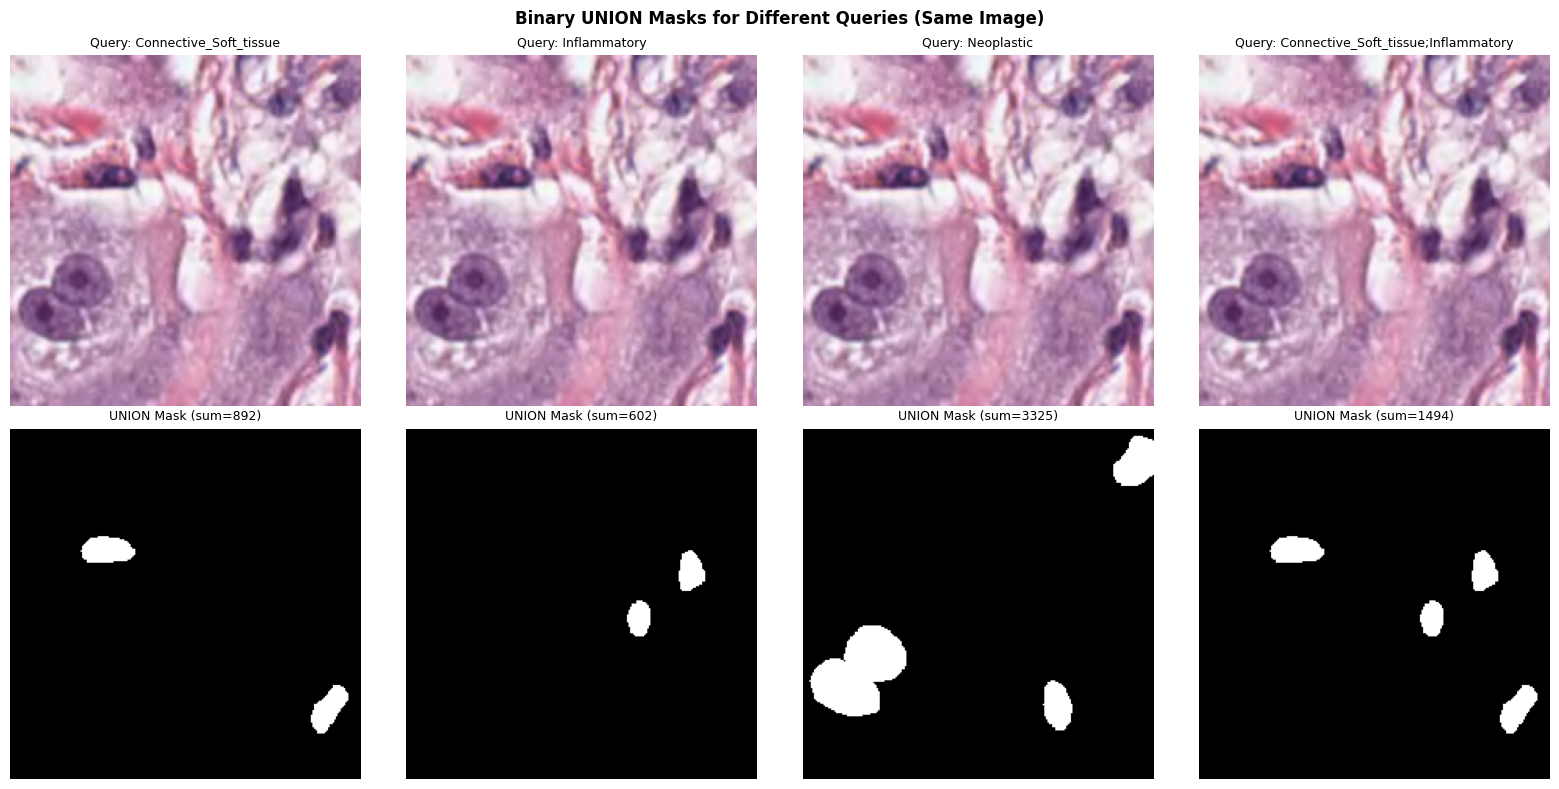


✓ Different queries produce different UNION masks!


In [4]:
# Cell 4: Verify UNION Mask Loading
print("🔍 Verifying UNION mask computation...")
print("="*80)

# Find instances of the same image with different queries
sample_image = df['image_path'].iloc[0]
sample_instances = df[df['image_path'] == sample_image].head(4)

temp_transform = A.Compose([A.Resize(224, 224)])
temp_dataset = BinaryUnionDataset(sample_instances, transform=temp_transform)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i in range(min(4, len(temp_dataset))):
    sample = temp_dataset[i]
    img = sample['image'].permute(1, 2, 0).numpy()
    mask = sample['mask'].squeeze().numpy()
    queried = sample['queried_classes']
    
    # Top row: images
    axes[0, i].imshow(img.astype(np.uint8) if img.max() > 1 else img)
    axes[0, i].set_title(f'Query: {queried}', fontsize=9)
    axes[0, i].axis('off')
    
    # Bottom row: union masks
    axes[1, i].imshow(mask, cmap='gray')
    axes[1, i].set_title(f'UNION Mask (sum={mask.sum():.0f})', fontsize=9)
    axes[1, i].axis('off')

plt.suptitle('Binary UNION Masks for Different Queries (Same Image)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✓ Different queries produce different UNION masks!")

## 3. Data Preparation

In [5]:
# Cell 5: Train-Val Split and DataLoaders

# Augmentations
train_transform = A.Compose([
    A.Resize(224, 224),
    # A.HorizontalFlip(p=0.5),
    # A.VerticalFlip(p=0.5),
    # A.RandomRotate90(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Collate function
def collate_fn(batch):
    images = torch.stack([item['image'] for item in batch])
    masks = torch.stack([item['mask'] for item in batch])
    instructions = [item['instruction'] for item in batch]
    return {
        'image': images,
        'mask': masks,
        'instruction': instructions
    }

# Split by unique images (not instances)
unique_images = df['image_path'].unique()
train_images, val_images = train_test_split(unique_images, test_size=0.2, random_state=42)

train_df = df[df['image_path'].isin(train_images)]
val_df = df[df['image_path'].isin(val_images)]

print(f"Train-Val Split (by unique images):")
print(f"  Train: {len(train_images)} images, {len(train_df)} instances")
print(f"  Val: {len(val_images)} images, {len(val_df)} instances")

# Create datasets
train_dataset = BinaryUnionDataset(train_df, transform=train_transform)
val_dataset = BinaryUnionDataset(val_df, transform=val_transform)

# Create dataloaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                          num_workers=0, pin_memory=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                        num_workers=0, pin_memory=True, collate_fn=collate_fn)

print(f"\n✓ DataLoaders created!")
print(f"  Batch size: {batch_size}")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")

Train-Val Split (by unique images):
  Train: 11 images, 77 instances
  Val: 3 images, 21 instances

✓ DataLoaders created!
  Batch size: 8
  Train batches: 10
  Val batches: 3


## 4. Initialize CIPS-Net for Binary Segmentation

In [6]:
# Cell 6: Initialize CIPS-Net with num_classes=1
print("Initializing CIPS-Net for Binary Segmentation...")
print("📦 ViT-B/16 + DistilBERT + num_classes=1")

model = CIPSNet(
    img_encoder_name='vit_b_16',
    text_encoder_name="distilbert-base-uncased",
    embed_dim=768,
    num_classes=1,  # BINARY SEGMENTATION
    img_size=224,
    num_graph_layers=3,
    decoder_channels=[512, 256, 128, 64],
    freeze_text_encoder=False,
    pretrained=True
)

model = model.to(device)
model.train()

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n✓ Model initialized!")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Output channels: 1 (binary mask)")

# Test forward pass
print("\nTesting forward pass...")
with torch.no_grad():
    test_img = torch.randn(2, 3, 224, 224).to(device)
    test_text = ["Segment Neoplastic tissue", "Segment Inflammatory and Dead"]
    output = model(test_img, test_text)
    print(f"  Input: {test_img.shape}")
    print(f"  Output: {output['masks'].shape}")
    print(f"  Expected: [2, 1, 224, 224]")
print("✓ Forward pass successful!")

Initializing CIPS-Net for Binary Segmentation...
📦 ViT-B/16 + DistilBERT + num_classes=1


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



✓ Model initialized!
  Total parameters: 115,783,937
  Trainable parameters: 115,783,937
  Output channels: 1 (binary mask)

Testing forward pass...
  Input: torch.Size([2, 3, 224, 224])
  Output: torch.Size([2, 1, 224, 224])
  Expected: [2, 1, 224, 224]
✓ Forward pass successful!


## 5. Loss Functions and Metrics

In [7]:
# Cell 7: Loss and Metrics for Binary Segmentation

def dice_score(pred, target, smooth=1e-6):
    """Binary Dice Score"""
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean()

def iou_score(pred, target, smooth=1e-6):
    """Binary IoU Score"""
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

class BinarySegmentationLoss(nn.Module):
    """Combined BCE + Dice Loss for Binary Segmentation"""
    
    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super().__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.bce = nn.BCEWithLogitsLoss()
    
    def dice_loss(self, pred, target, smooth=1e-6):
        pred = torch.sigmoid(pred)
        intersection = (pred * target).sum(dim=(2, 3))
        union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
        dice = (2. * intersection + smooth) / (union + smooth)
        return 1 - dice.mean()
    
    def forward(self, pred, target):
        bce = self.bce(pred, target)
        dice = self.dice_loss(pred, target)
        return self.bce_weight * bce + self.dice_weight * dice

print("✓ Binary segmentation loss and metrics defined!")

✓ Binary segmentation loss and metrics defined!


## 6. Training Configuration

In [8]:
# Cell 8: Training Setup
num_epochs = 10
learning_rate = 1e-4
weight_decay = 1e-5

criterion = BinarySegmentationLoss(bce_weight=0.5, dice_weight=0.5)
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)

# Ensure gradients are enabled
model.train()
for param in model.parameters():
    param.requires_grad = True

print("✓ Training configuration:")
print(f"  Epochs: {num_epochs}")
print(f"  Learning rate: {learning_rate}")
print(f"  Optimizer: AdamW")
print(f"  Scheduler: ReduceLROnPlateau (patience=5)")
print(f"  Loss: BCE + Dice (0.5 + 0.5)")

✓ Training configuration:
  Epochs: 10
  Learning rate: 0.0001
  Optimizer: AdamW
  Scheduler: ReduceLROnPlateau (patience=5)
  Loss: BCE + Dice (0.5 + 0.5)


In [9]:
# Cell 9: Training and Validation Functions

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_dice = 0.0
    running_iou = 0.0
    num_batches = 0
    
    pbar = tqdm(loader, desc='Training', leave=False)
    for batch in pbar:
        images = batch['image'].to(device)
        masks = batch['mask'].to(device)
        instructions = batch['instruction']
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images, instructions)
        pred_masks = outputs['masks']
        
        # Loss
        loss = criterion(pred_masks, masks)
        
        # Backward
        loss.backward()
        optimizer.step()
        
        # Metrics
        with torch.no_grad():
            pred_sigmoid = torch.sigmoid(pred_masks)
            dice = dice_score(pred_sigmoid, masks)
            iou = iou_score(pred_sigmoid, masks)
        
        running_loss += loss.item()
        running_dice += dice.item()
        running_iou += iou.item()
        num_batches += 1
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'dice': f'{dice.item():.4f}'})
    
    return running_loss / num_batches, running_dice / num_batches, running_iou / num_batches


def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_dice = 0.0
    running_iou = 0.0
    num_batches = 0
    
    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation', leave=False)
        for batch in pbar:
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)
            instructions = batch['instruction']
            
            # Forward pass
            outputs = model(images, instructions)
            pred_masks = outputs['masks']
            
            # Loss and metrics
            loss = criterion(pred_masks, masks)
            pred_sigmoid = torch.sigmoid(pred_masks)
            dice = dice_score(pred_sigmoid, masks)
            iou = iou_score(pred_sigmoid, masks)
            
            running_loss += loss.item()
            running_dice += dice.item()
            running_iou += iou.item()
            num_batches += 1
            
            pbar.set_postfix({'loss': f'{loss.item():.4f}', 'dice': f'{dice.item():.4f}'})
    
    return running_loss / num_batches, running_dice / num_batches, running_iou / num_batches

print("✓ Training and validation functions defined!")

✓ Training and validation functions defined!


## 7. Train the Model

In [10]:
# Cell 10: Main Training Loop
best_dice = 0.0
patience = 5
patience_counter = 0

history = {
    'train_loss': [], 'val_loss': [],
    'train_dice': [], 'val_dice': [],
    'train_iou': [], 'val_iou': []
}

print("="*70)
print("CIPS-Net Binary Segmentation Training")
print("="*70)
print(f"Training instances: {len(train_loader.dataset)}")
print(f"Validation instances: {len(val_loader.dataset)}")
print(f"Output: Single channel (UNION of queried masks)")
print("="*70 + "\n")

for epoch in range(num_epochs):
    # Training
    train_loss, train_dice, train_iou = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validation
    val_loss, val_dice, val_iou = validate_epoch(model, val_loader, criterion, device)
    
    # Store history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_dice'].append(train_dice)
    history['val_dice'].append(val_dice)
    history['train_iou'].append(train_iou)
    history['val_iou'].append(val_iou)
    
    # Scheduler step
    scheduler.step(val_dice)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Print summary
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    print(f"  Train - Loss: {train_loss:.4f}, Dice: {train_dice:.4f}, IoU: {train_iou:.4f}")
    print(f"  Val   - Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}")
    print(f"  LR: {current_lr:.2e}")
    
    # Save best model
    if val_dice > best_dice:
        best_dice = val_dice
        patience_counter = 0
        
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_dice': best_dice,
            'history': history
        }
        torch.save(checkpoint, 'best_cipsnet_binary.pth')
        print(f"  *** New Best Model! Dice: {best_dice:.4f} ***")
    else:
        patience_counter += 1
        print(f"  No improvement. Patience: {patience_counter}/{patience}")
    
    # Early stopping
    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

print("\n" + "="*70)
print(f"Training Complete! Best Dice: {best_dice:.4f}")
print("="*70)

CIPS-Net Binary Segmentation Training
Training instances: 77
Validation instances: 21
Output: Single channel (UNION of queried masks)



Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch [1/10]
  Train - Loss: 0.7368, Dice: 0.0995, IoU: 0.0544
  Val   - Loss: 0.7841, Dice: 0.1277, IoU: 0.0698
  LR: 1.00e-04
  *** New Best Model! Dice: 0.1277 ***


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch [2/10]
  Train - Loss: 0.7332, Dice: 0.0998, IoU: 0.0543
  Val   - Loss: 0.7635, Dice: 0.1079, IoU: 0.0580
  LR: 1.00e-04
  No improvement. Patience: 1/5


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch [3/10]
  Train - Loss: 0.7295, Dice: 0.0996, IoU: 0.0543
  Val   - Loss: 0.7222, Dice: 0.1607, IoU: 0.0896
  LR: 1.00e-04
  *** New Best Model! Dice: 0.1607 ***


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch [4/10]
  Train - Loss: 0.7061, Dice: 0.2275, IoU: 0.1438
  Val   - Loss: 0.5885, Dice: 0.1637, IoU: 0.0960
  LR: 1.00e-04
  *** New Best Model! Dice: 0.1637 ***


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch [5/10]
  Train - Loss: 0.6687, Dice: 0.3532, IoU: 0.2460
  Val   - Loss: 0.5559, Dice: 0.4405, IoU: 0.3056
  LR: 1.00e-04
  *** New Best Model! Dice: 0.4405 ***


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch [6/10]
  Train - Loss: 0.6388, Dice: 0.4234, IoU: 0.3169
  Val   - Loss: 0.6033, Dice: 0.1700, IoU: 0.0970
  LR: 1.00e-04
  No improvement. Patience: 1/5


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch [7/10]
  Train - Loss: 0.6081, Dice: 0.4619, IoU: 0.3603
  Val   - Loss: 0.5851, Dice: 0.3530, IoU: 0.2500
  LR: 1.00e-04
  No improvement. Patience: 2/5


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch [8/10]
  Train - Loss: 0.5684, Dice: 0.5099, IoU: 0.4089
  Val   - Loss: 0.5753, Dice: 0.3532, IoU: 0.2612
  LR: 1.00e-04
  No improvement. Patience: 3/5


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch [9/10]
  Train - Loss: 0.5488, Dice: 0.4835, IoU: 0.3957
  Val   - Loss: 0.5552, Dice: 0.3871, IoU: 0.2856
  LR: 1.00e-04
  No improvement. Patience: 4/5


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch [10/10]
  Train - Loss: 0.5470, Dice: 0.4825, IoU: 0.3995
  Val   - Loss: 0.5501, Dice: 0.3547, IoU: 0.2439
  LR: 1.00e-04
  No improvement. Patience: 5/5

Early stopping at epoch 10

Training Complete! Best Dice: 0.4405


## 8. Training History Visualization

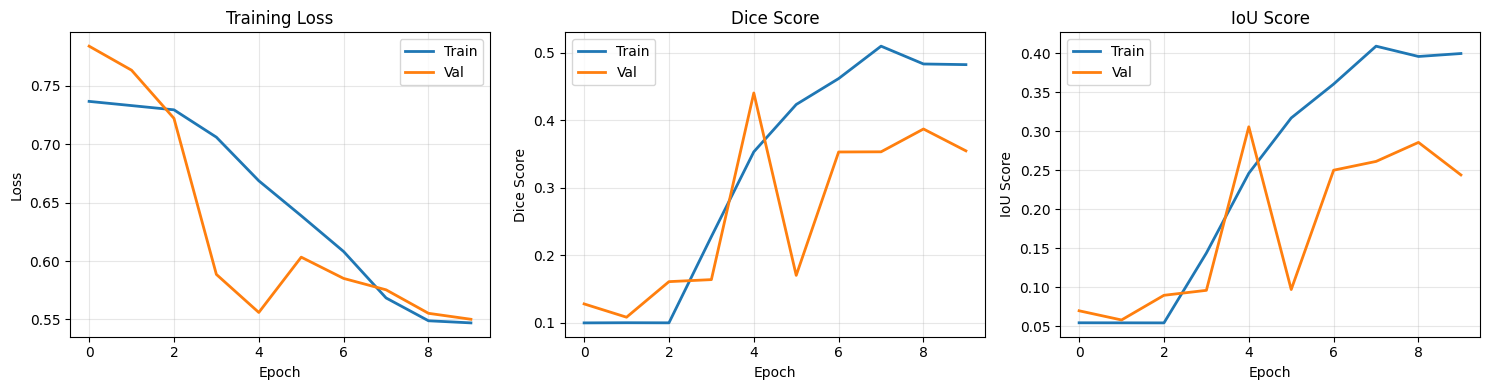


Best Validation Dice: 0.4405 at epoch 5


In [11]:
# Cell 11: Plot Training History
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss
axes[0].plot(history['train_loss'], label='Train', linewidth=2)
axes[0].plot(history['val_loss'], label='Val', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Dice
axes[1].plot(history['train_dice'], label='Train', linewidth=2)
axes[1].plot(history['val_dice'], label='Val', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Dice Score')
axes[1].set_title('Dice Score')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# IoU
axes[2].plot(history['train_iou'], label='Train', linewidth=2)
axes[2].plot(history['val_iou'], label='Val', linewidth=2)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('IoU Score')
axes[2].set_title('IoU Score')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('binary_training_history.png', dpi=150)
plt.show()

print(f"\nBest Validation Dice: {max(history['val_dice']):.4f} at epoch {np.argmax(history['val_dice'])+1}")

## 9. Visualize Model Predictions

This is the **key visualization** showing:
- Same image with different text queries → different binary mask outputs

In [12]:
# Cell 12: Load Best Model for Visualization
checkpoint = torch.load('best_cipsnet_binary.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print(f"✓ Loaded best model from epoch {checkpoint['epoch']} with Dice: {checkpoint['best_dice']:.4f}")

C:\Users\nikhi\AppData\Local\Temp\ipykernel_7752\398266373.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_cipsnet_binary.pth', map_locatio

✓ Loaded best model from epoch 5 with Dice: 0.4405


In [13]:
# Cell 13: Visualization Function
def visualize_compositional_predictions(model, image_path, queries, device, img_size=224):
    """
    Visualize how the model responds to different text queries on the SAME image.
    This demonstrates text-conditional binary segmentation.
    """
    model.eval()
    
    # Load and preprocess image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original = image.copy()
    
    # Resize and normalize
    image_resized = cv2.resize(image, (img_size, img_size))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_norm = (image_resized / 255.0 - mean) / std
    image_tensor = torch.from_numpy(image_norm).permute(2, 0, 1).float().unsqueeze(0).to(device)
    
    num_queries = len(queries)
    fig, axes = plt.subplots(3, num_queries + 1, figsize=(4 * (num_queries + 1), 10))
    
    # First column: original image
    axes[0, 0].imshow(cv2.resize(original, (img_size, img_size)))
    axes[0, 0].set_title('Original Image', fontsize=11, fontweight='bold')
    axes[0, 0].axis('off')
    axes[1, 0].axis('off')
    axes[2, 0].axis('off')
    
    with torch.no_grad():
        for q_idx, query in enumerate(queries):
            # Get prediction
            output = model(image_tensor, [query])
            pred = torch.sigmoid(output['masks']).cpu().numpy()[0, 0]
            binary_pred = (pred > 0.5).astype(np.float32)
            
            # Row 1: Probability map
            axes[0, q_idx + 1].imshow(pred, cmap='hot', vmin=0, vmax=1)
            axes[0, q_idx + 1].set_title(f'Probability Map', fontsize=10)
            axes[0, q_idx + 1].axis('off')
            
            # Row 2: Binary mask
            axes[1, q_idx + 1].imshow(binary_pred, cmap='gray')
            axes[1, q_idx + 1].set_title(f'Binary Mask', fontsize=10)
            axes[1, q_idx + 1].axis('off')
            
            # Row 3: Overlay
            overlay = cv2.resize(original, (img_size, img_size)).astype(np.float32) / 255.0
            mask_rgb = np.zeros_like(overlay)
            mask_rgb[:, :, 0] = binary_pred  # Red channel
            blended = overlay * 0.6 + mask_rgb * 0.4
            blended = np.clip(blended, 0, 1)
            axes[2, q_idx + 1].imshow(blended)
            axes[2, q_idx + 1].set_title(f'Overlay', fontsize=10)
            axes[2, q_idx + 1].axis('off')
            
            # Add query as column title
            query_short = query[:35] + '...' if len(query) > 35 else query
            fig.text((q_idx + 1.5) / (num_queries + 1), 0.98, query_short, 
                     ha='center', va='top', fontsize=10, fontweight='bold',
                     bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.suptitle('Text-Conditional Binary Segmentation: Same Image, Different Queries', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('compositional_binary_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()

print("✓ Visualization function defined!")

✓ Visualization function defined!


Testing on image: 1_Breast_fold_1_0000_img.png

Queries:
  1. Segment Neoplastic tissue
  2. Segment Inflammatory cells
  3. Segment Neoplastic and Inflammatory
  4. Segment Connective Soft tissue and Epithelial and Dead


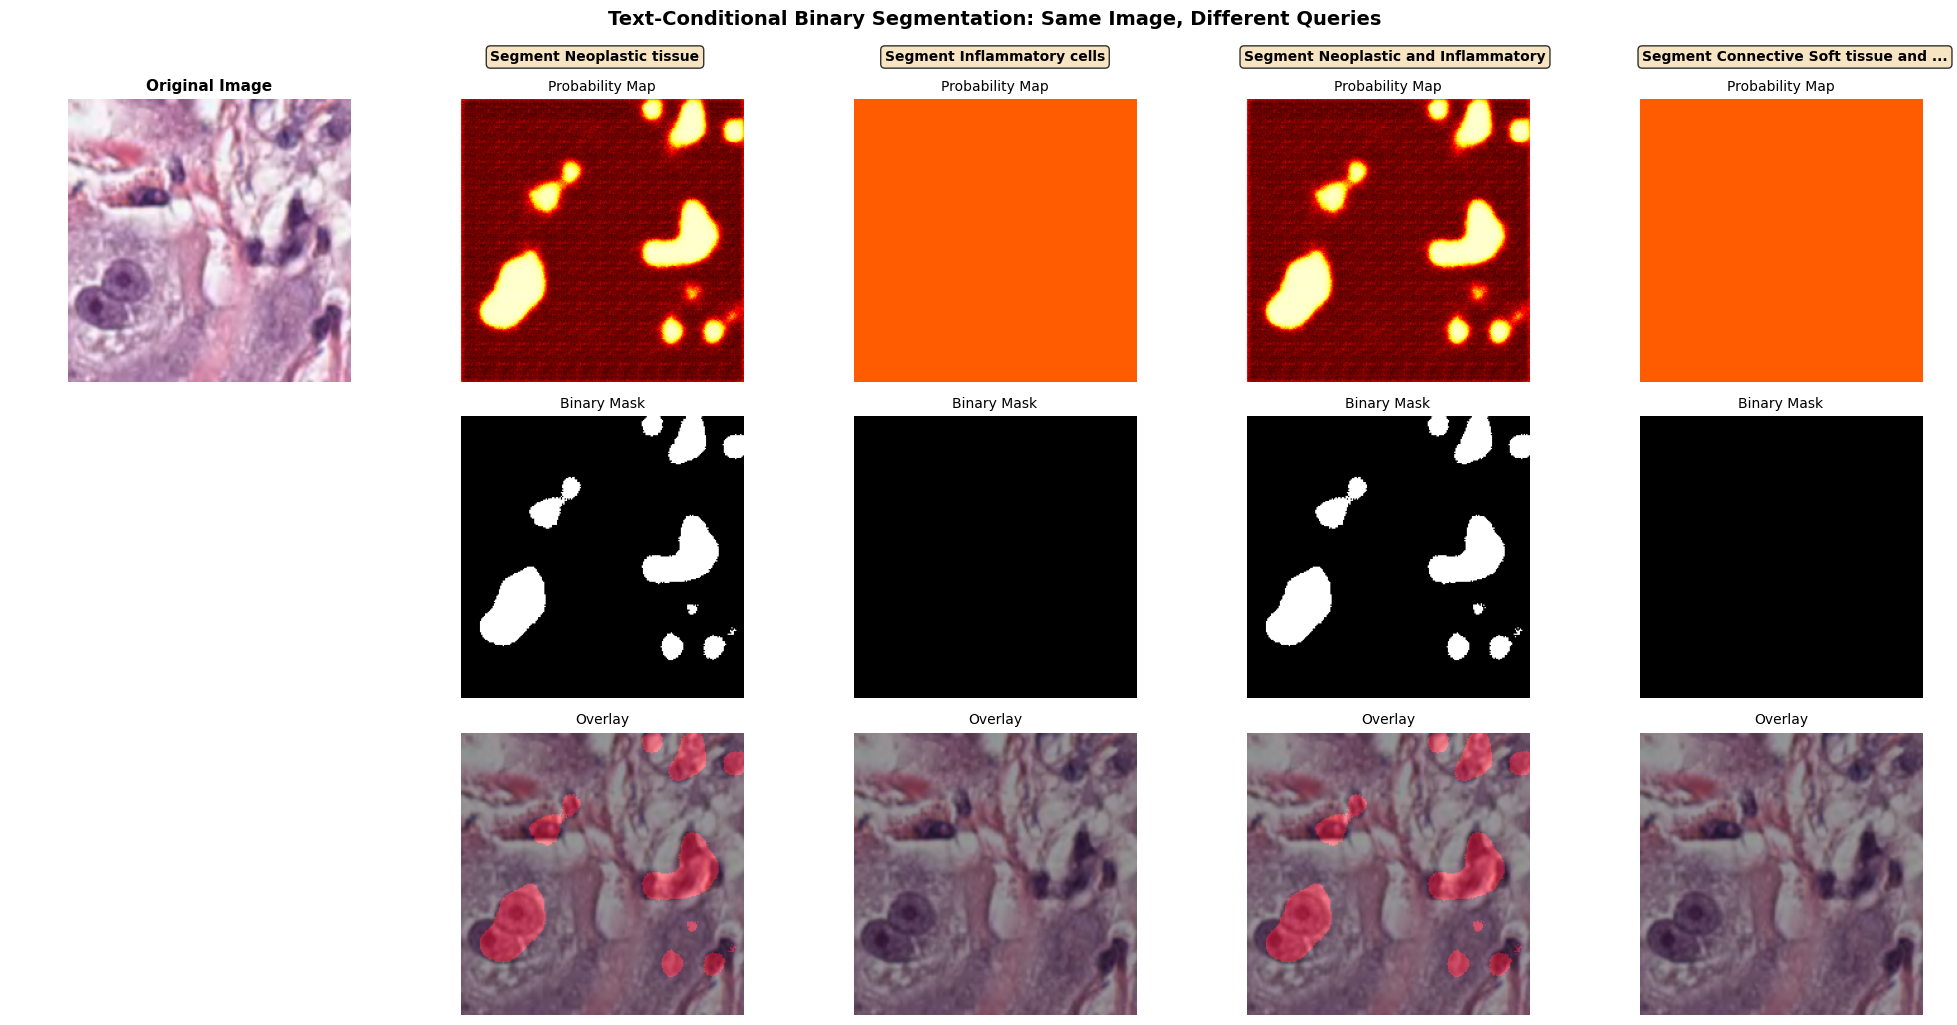

In [14]:
# Cell 14: Visualize Compositional Predictions
# Get a sample image from validation set
sample_image_path = os.path.join('Dataset/multi_images', val_df['image_path'].iloc[0])

# Define different compositional queries for the SAME image
test_queries = [
    "Segment Neoplastic tissue",
    "Segment Inflammatory cells",
    "Segment Neoplastic and Inflammatory",
    "Segment Connective Soft tissue and Epithelial and Dead"
]

print(f"Testing on image: {val_df['image_path'].iloc[0]}")
print("\nQueries:")
for i, q in enumerate(test_queries, 1):
    print(f"  {i}. {q}")

visualize_compositional_predictions(model, sample_image_path, test_queries, device)

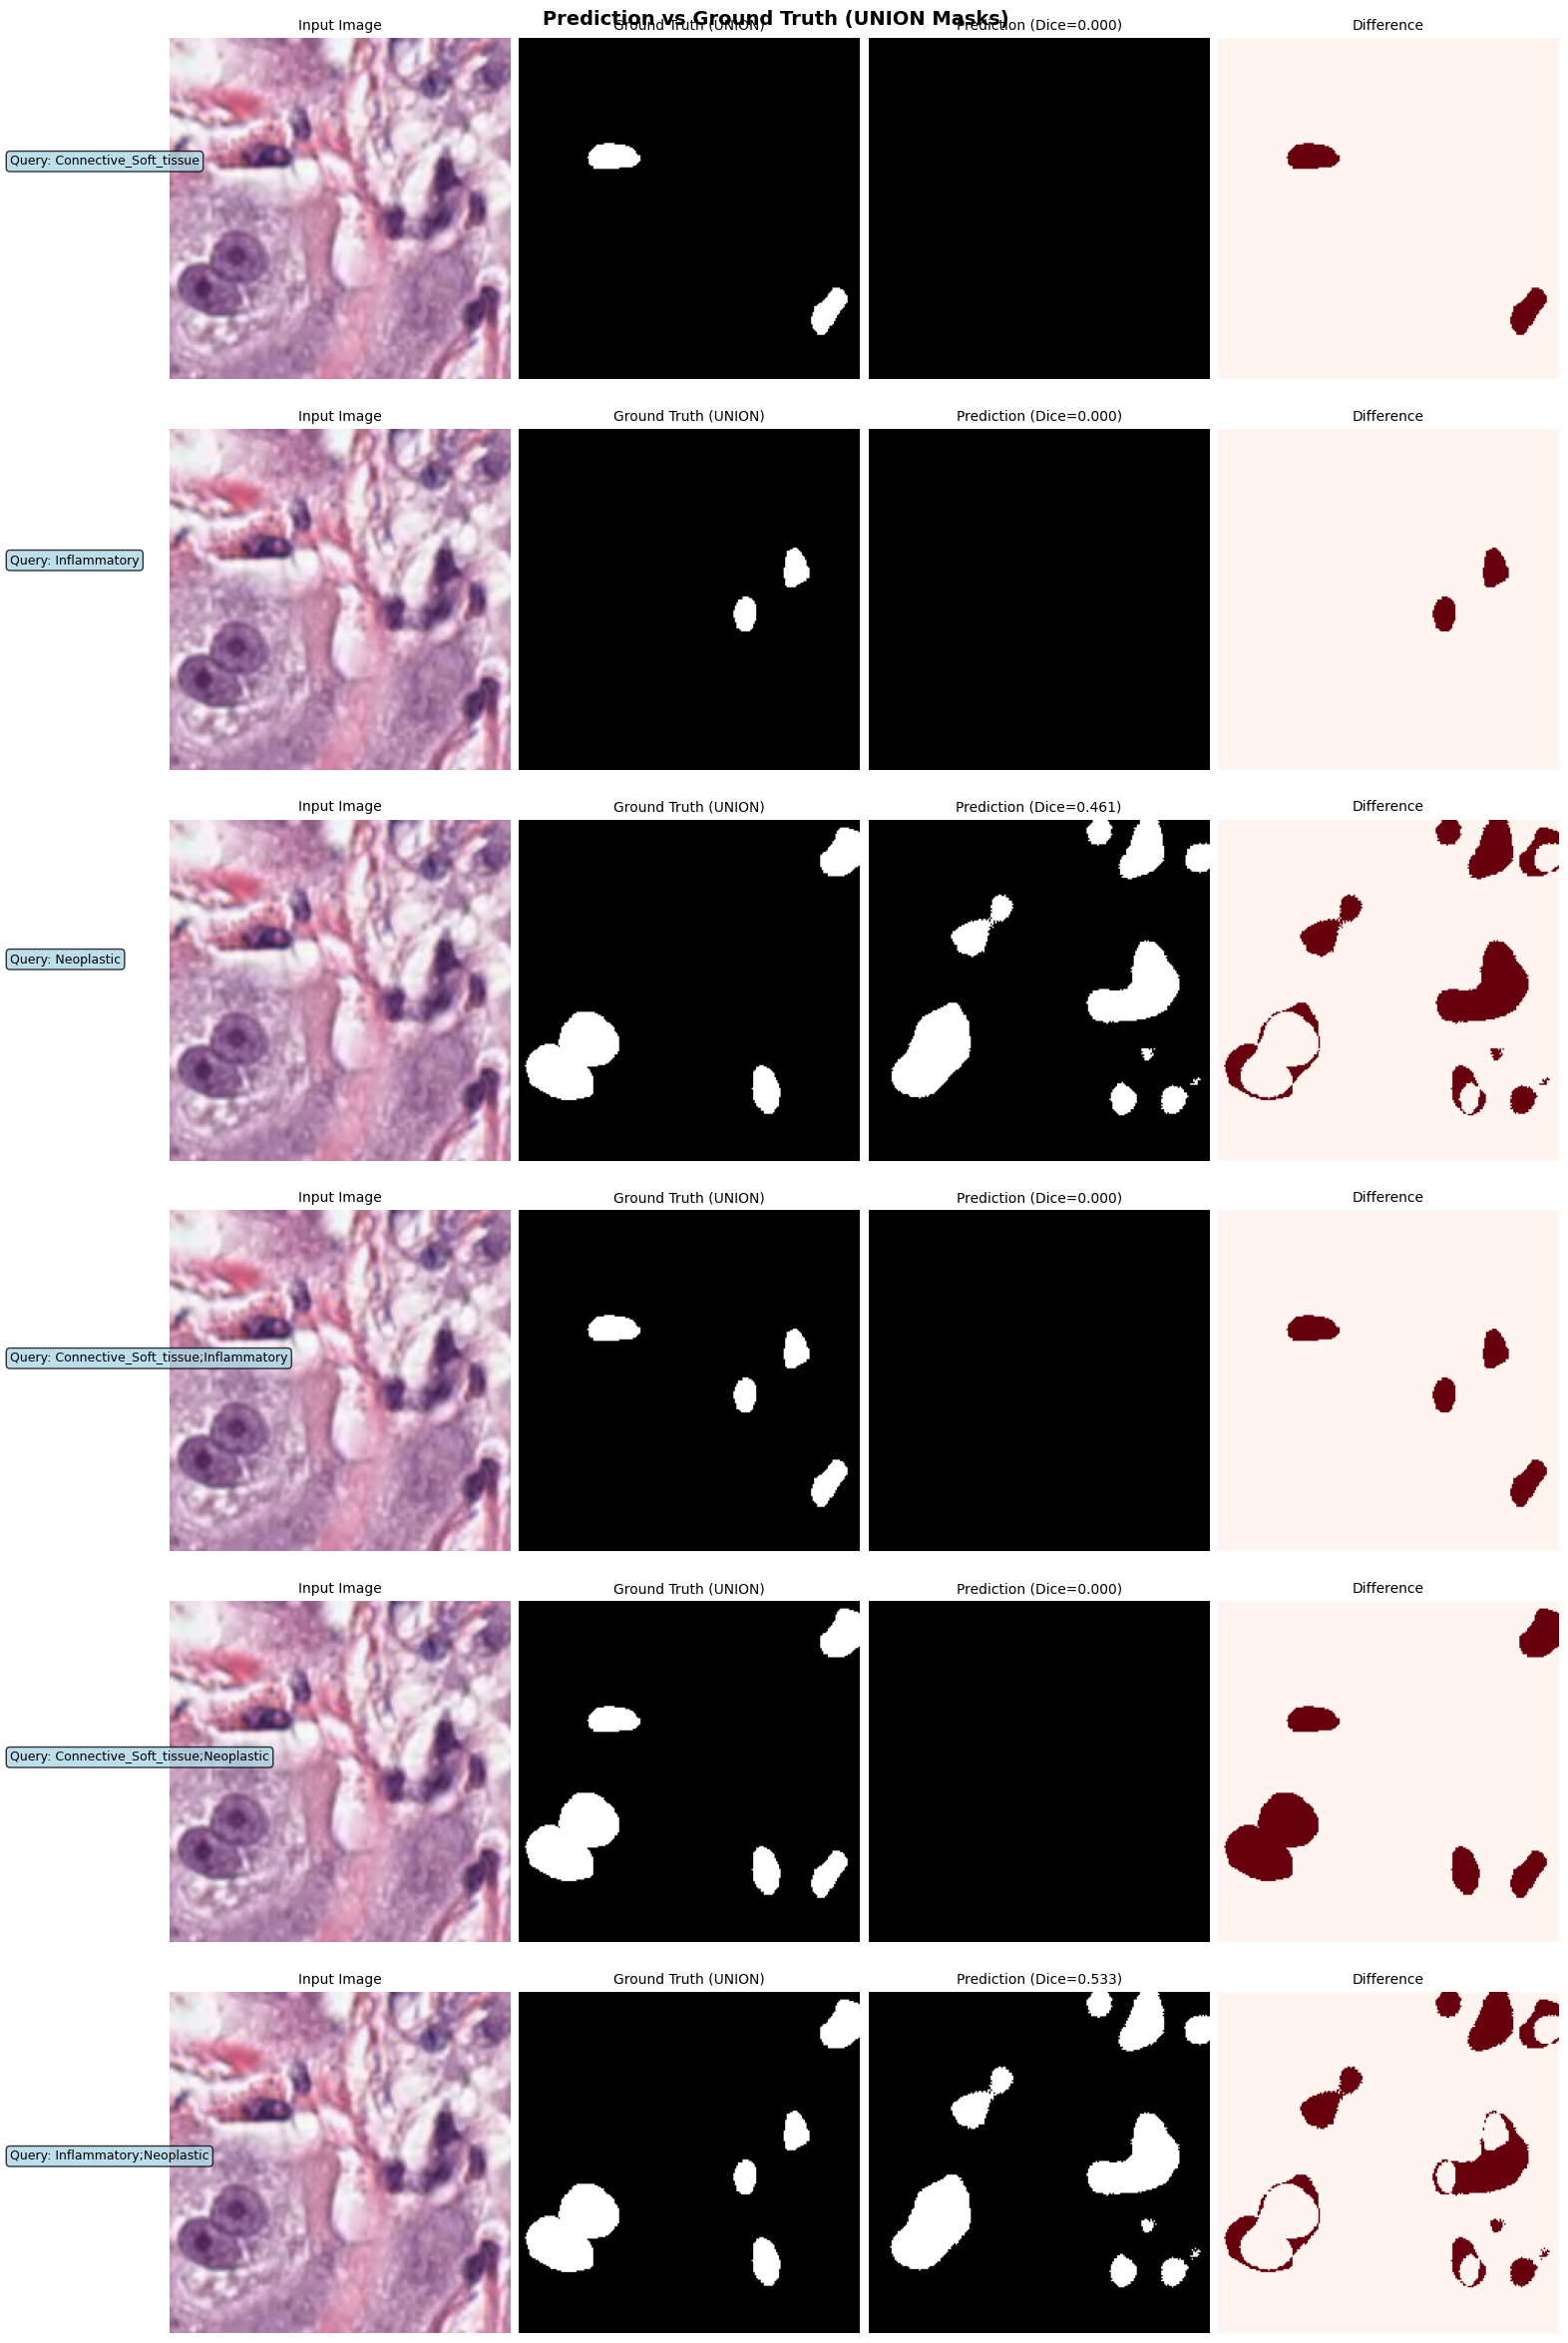

In [15]:
# Cell 15: Compare Predictions vs Ground Truth
def compare_predictions_vs_gt(model, dataset, indices, device):
    """
    Side-by-side comparison of predictions and ground truth.
    """
    model.eval()
    
    num_samples = len(indices)
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4 * num_samples))
    
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    with torch.no_grad():
        for row, idx in enumerate(indices):
            sample = dataset[idx]
            image = sample['image'].unsqueeze(0).to(device)
            gt_mask = sample['mask'].squeeze().numpy()
            query = sample['instruction']
            queried_classes = sample['queried_classes']
            
            # Prediction
            output = model(image, [query])
            pred = torch.sigmoid(output['masks']).cpu().numpy()[0, 0]
            binary_pred = (pred > 0.5).astype(np.float32)
            
            # Denormalize image for display
            img_display = sample['image'].permute(1, 2, 0).numpy()
            img_display = img_display * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img_display = np.clip(img_display, 0, 1)
            
            # Calculate Dice for this sample
            intersection = (binary_pred * gt_mask).sum()
            union = binary_pred.sum() + gt_mask.sum()
            sample_dice = (2 * intersection + 1e-6) / (union + 1e-6)
            
            # Plot
            axes[row, 0].imshow(img_display)
            axes[row, 0].set_title('Input Image', fontsize=10)
            axes[row, 0].axis('off')
            
            axes[row, 1].imshow(gt_mask, cmap='gray')
            axes[row, 1].set_title(f'Ground Truth (UNION)', fontsize=10)
            axes[row, 1].axis('off')
            
            axes[row, 2].imshow(binary_pred, cmap='gray')
            axes[row, 2].set_title(f'Prediction (Dice={sample_dice:.3f})', fontsize=10)
            axes[row, 2].axis('off')
            
            # Difference
            diff = np.abs(gt_mask - binary_pred)
            axes[row, 3].imshow(diff, cmap='Reds')
            axes[row, 3].set_title('Difference', fontsize=10)
            axes[row, 3].axis('off')
            
            # Add query label
            query_short = queried_classes[:40]
            fig.text(0.02, (num_samples - row - 0.5) / num_samples, 
                     f'Query: {query_short}', fontsize=9, va='center',
                     bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.suptitle('Prediction vs Ground Truth (UNION Masks)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.subplots_adjust(left=0.12)
    plt.savefig('binary_prediction_vs_gt.png', dpi=150, bbox_inches='tight')
    plt.show()

# Visualize samples
test_indices = list(range(min(6, len(val_dataset))))
compare_predictions_vs_gt(model, val_dataset, test_indices, device)

Image: 1_Breast_fold_1_0000_img.png
Number of query instances: 6


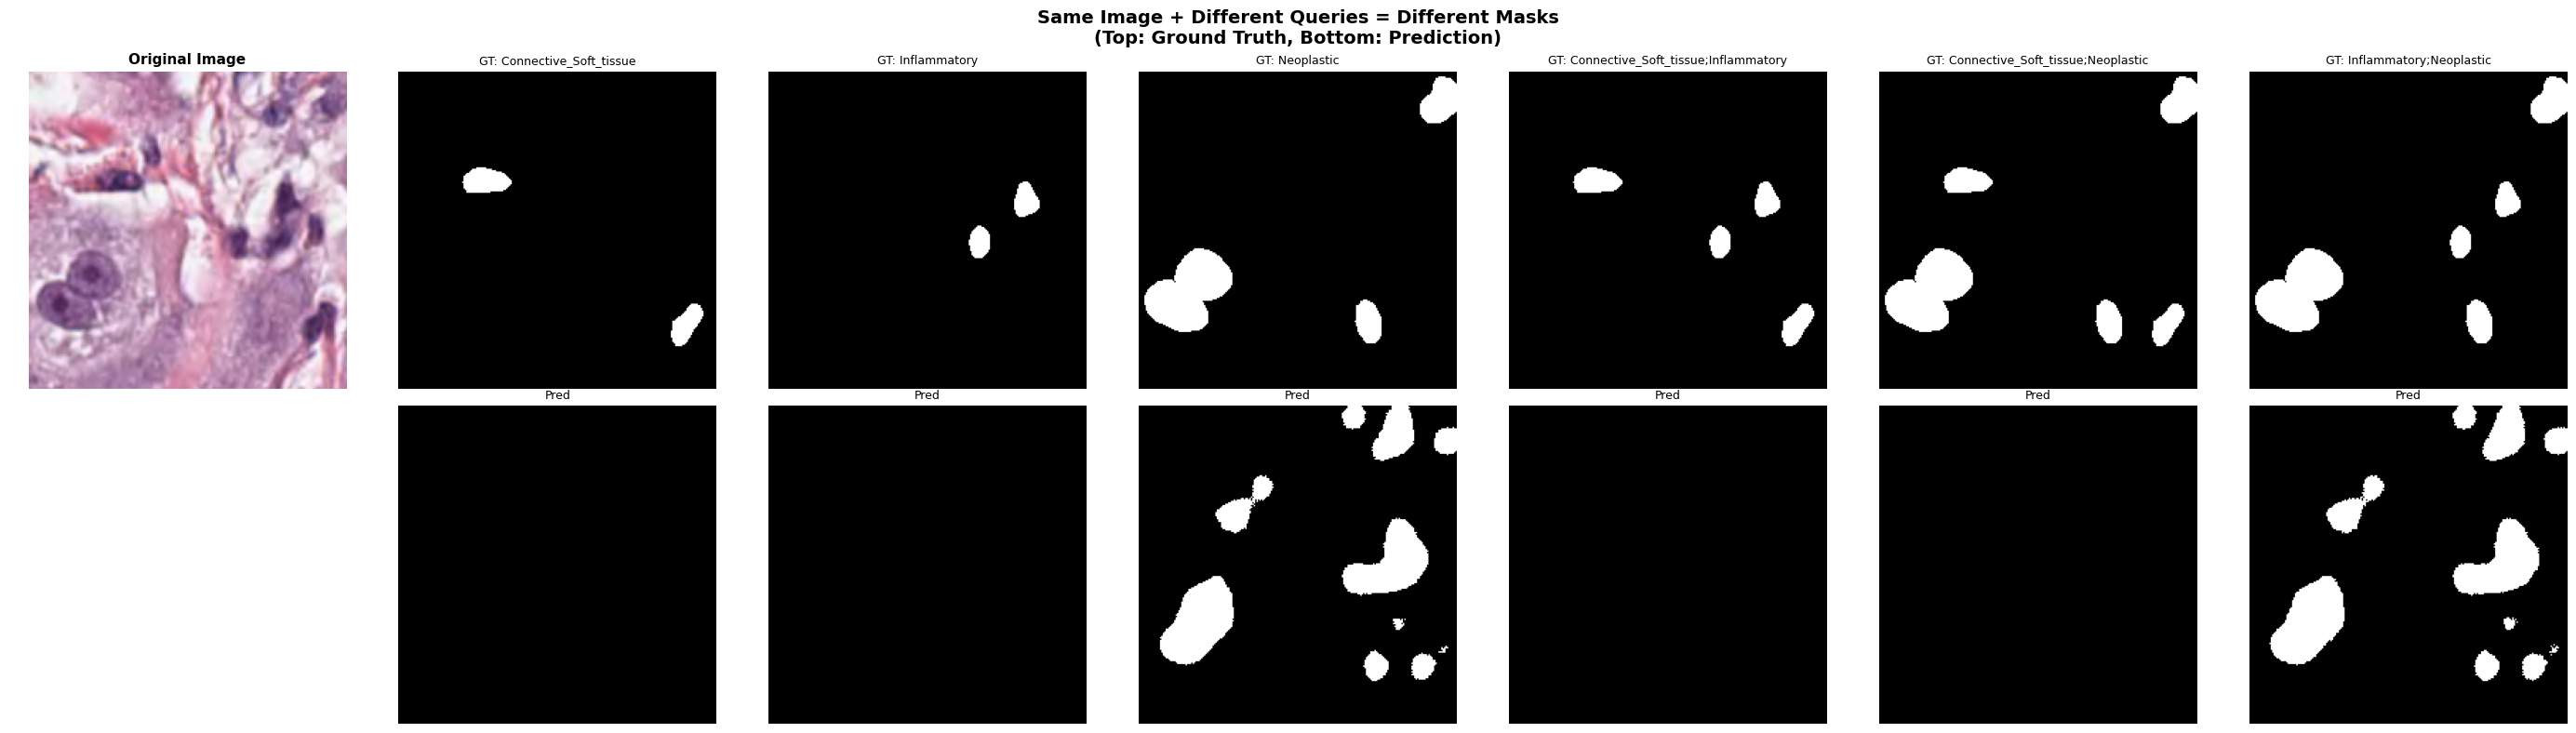

In [16]:
# Cell 16: Test Same Image with Different Queries (Key Demo)
def demo_same_image_different_queries(model, df, device, img_size=224):
    """
    The key demonstration: same image with different queries produces different masks.
    """
    model.eval()
    
    # Find an image with multiple instances
    image_counts = df['image_path'].value_counts()
    sample_image = image_counts.idxmax()  # Image with most instances
    instances = df[df['image_path'] == sample_image].head(6)
    
    print(f"Image: {sample_image}")
    print(f"Number of query instances: {len(instances)}")
    
    # Load image
    img_path = os.path.join('Dataset/multi_images', sample_image)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image, (img_size, img_size))
    
    # Normalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_norm = (image_resized / 255.0 - mean) / std
    image_tensor = torch.from_numpy(image_norm).permute(2, 0, 1).float().unsqueeze(0).to(device)
    
    num_instances = len(instances)
    fig, axes = plt.subplots(2, num_instances + 1, figsize=(4 * (num_instances + 1), 8))
    
    # Original image
    axes[0, 0].imshow(image_resized)
    axes[0, 0].set_title('Original Image', fontsize=11, fontweight='bold')
    axes[0, 0].axis('off')
    axes[1, 0].axis('off')
    
    with torch.no_grad():
        for i, (_, row) in enumerate(instances.iterrows()):
            query = row['instruction']
            queried_classes = row['classes']
            
            # Prediction
            output = model(image_tensor, [query])
            pred = torch.sigmoid(output['masks']).cpu().numpy()[0, 0]
            binary_pred = (pred > 0.5).astype(np.float32)
            
            # Load ground truth UNION mask
            base_name = row['base_name']
            gt_union = np.zeros((img_size, img_size), dtype=np.uint8)
            for class_name in queried_classes.split(';'):
                if class_name in CHANNEL_MAPPING:
                    ch = CHANNEL_MAPPING[class_name]
                    mask_path = f"Dataset/multi_masks/{base_name}_channel_{ch}_{class_name}.png"
                    if os.path.exists(mask_path):
                        m = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                        m = cv2.resize(m, (img_size, img_size))
                        gt_union = np.maximum(gt_union, (m > 127).astype(np.uint8))
            
            # Row 1: Ground Truth
            axes[0, i + 1].imshow(gt_union, cmap='gray')
            axes[0, i + 1].set_title(f'GT: {queried_classes}', fontsize=9)
            axes[0, i + 1].axis('off')
            
            # Row 2: Prediction
            axes[1, i + 1].imshow(binary_pred, cmap='gray')
            axes[1, i + 1].set_title(f'Pred', fontsize=9)
            axes[1, i + 1].axis('off')
    
    plt.suptitle('Same Image + Different Queries = Different Masks\n(Top: Ground Truth, Bottom: Prediction)', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('same_image_different_queries.png', dpi=150, bbox_inches='tight')
    plt.show()

demo_same_image_different_queries(model, val_df, device)

In [17]:
# Cell 17: Quantitative Analysis
print("="*70)
print("QUANTITATIVE ANALYSIS")
print("="*70)

# Evaluate on full validation set
model.eval()
all_dice = []
all_iou = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc='Evaluating'):
        images = batch['image'].to(device)
        masks = batch['mask'].to(device)
        instructions = batch['instruction']
        
        outputs = model(images, instructions)
        pred = torch.sigmoid(outputs['masks'])
        
        dice = dice_score(pred, masks)
        iou = iou_score(pred, masks)
        
        all_dice.append(dice.item())
        all_iou.append(iou.item())

mean_dice = np.mean(all_dice)
std_dice = np.std(all_dice)
mean_iou = np.mean(all_iou)
std_iou = np.std(all_iou)

print(f"\nValidation Results:")
print(f"  Dice Score: {mean_dice:.4f} ± {std_dice:.4f}")
print(f"  IoU Score:  {mean_iou:.4f} ± {std_iou:.4f}")
print("="*70)

QUANTITATIVE ANALYSIS


Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Validation Results:
  Dice Score: 0.4405 ± 0.1026
  IoU Score:  0.3056 ± 0.0865


In [18]:
# Cell 18: Summary
print("\n" + "="*70)
print("TRAINING SUMMARY")
print("="*70)
print(f"\nModel: CIPS-Net (ViT-B/16 + DistilBERT)")
print(f"Task: Text-Conditional Binary Segmentation")
print(f"Output: Single channel (UNION of queried class masks)")
print(f"\nDataset:")
print(f"  - Training instances: {len(train_df)}")
print(f"  - Validation instances: {len(val_df)}")
print(f"\nBest Results:")
print(f"  - Best Dice: {best_dice:.4f}")
print(f"  - Best Epoch: {checkpoint['epoch']}")
print(f"\nKey Feature:")
print(f"  Same image + different text queries → different binary masks")
print(f"  Ground truth = UNION of masks for classes mentioned in query")
print("="*70)


TRAINING SUMMARY

Model: CIPS-Net (ViT-B/16 + DistilBERT)
Task: Text-Conditional Binary Segmentation
Output: Single channel (UNION of queried class masks)

Dataset:
  - Training instances: 77
  - Validation instances: 21

Best Results:
  - Best Dice: 0.4405
  - Best Epoch: 5

Key Feature:
  Same image + different text queries → different binary masks
  Ground truth = UNION of masks for classes mentioned in query
